In [1]:
# imports

import os
import sys
import json
import time
import joblib
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

thisdir = os.getcwd()
topdir = os.path.abspath(os.path.join(thisdir, '../../../'))
sys.path.append(topdir)

import tools.iotools as iotools
import tools.dftools as dftools
import tools.patternfiltering as patternfiltering
import tools.rebinning as rebinning
import tools.clustering as clustering
import plotting.plottools as plottools
from automasking.tools.automaskreader import AutomaskReader
from studies.pixel_clusters_2024.preprocessing.preprocessor import PreProcessor
from studies.pixel_clusters_2024.preprocessing.preprocessor import get_metype
from studies.pixel_clusters_2024.plotting.plot_cluster_occupancy import plot_cluster_occupancy
from studies.pixel_clusters_2024.nmf.nmf_testing_pattern import make_preprocessors
from studies.pixel_clusters_2024.nmf.nmf_testing_pattern import load_nmfs

In [2]:
# set era and layers

era = '2025F-v1'
layers = [
    #'BPix1',
    'BPix2',
    'BPix3',
    'BPix4'
]

In [3]:
# read config file

#config_file = None
config_file = f'output_test/temp_config_{era}.json'

if config_file is not None:
    
    # read config file
    with open(config_file, 'r') as f:
        config = json.load(f)
        
    # read eras
    eras = config['eras']

    # make preprocessors and models
    print('Making preprocessors...')
    global_normalization = config.get('preprocessing_global_normalization', None)
    local_normalization = config.get('preprocessing_local_normalization', None)
    preprocessors = make_preprocessors(eras, layers,
                      global_normalization = global_normalization,
                      local_normalization = local_normalization)
    print('Loading NMFs...')
    nmfs = load_nmfs(config['nmf_files'])
    
    # get evaluation settings
    batch_size = config['batch_size']
    flagging_patterns = [np.array(el) for el in config['flagging_patterns']]
    flagging_threshold = config['flagging_threshold']
    pattern_thresholds = config['pattern_thresholds'] # change in syntax, need to set below
    do_automasking = config['do_automasking']
    do_loss_masking = config['do_loss_masking']

    # make automask reader if needed
    automask_reader = None
    automask_map_preprocessors = None
    if do_automasking:
        automask_reader = AutomaskReader(config['automask_data_file'])
        automask_map_preprocessors = {}
        for layer in layers: automask_map_preprocessors[layer] = PreProcessor(f'PXLayer_{layer}')

    # make loss mask if needed
    loss_masks = None
    loss_mask_preprocessors = None
    if do_loss_masking:
        loss_masks = {}
        loss_mask_preprocessors = {}
        for era in eras:
            loss_masks[era] = {}
            for layer in layers:
                loss_mask_file = config['loss_masking_zero_frac_files'][era][layer]
                loss_mask = np.load(loss_mask_file)
                loss_mask = (loss_mask < config['loss_masking_zero_frac_threshold'])
                loss_masks[era][layer] = loss_mask
        for layer in layers: loss_mask_preprocessors[layer] = PreProcessor(f'PXLayer_{layer}')

Making preprocessors...
Loading NMFs...


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MiniBatchNMF from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# set path to input files

# settings
datadir = '/eos/user/l/llambrec/dialstools-output'
dataset = 'ZeroBias'
reco = 'PromptReco'
mebase = 'PixelPhase1-Phase1_MechanicalView-PXBarrel-'
mebase += 'clusters_per_SignedModuleCoord_per_SignedLadderCoord_PXLayer_'

# find files corresponding to settings
input_files = {}
mainera, version = era.split('-', 1)
input_files[era] = {}
for layer in layers:
    f = f'{dataset}-Run{mainera}-{reco}-{version}-DQMIO-{mebase}{layer[-1]}.parquet'
    f = os.path.join(datadir, f)
    input_files[era][layer] = f
    
# existence check
missing = []
present = []
for _, values in input_files.items():
    for layer, f in values.items():
        if not os.path.exists(f): missing.append(f)
        else: present.append(f)
if len(missing) > 0:
    raise Exception(f'The following files do not exist: {missing}')
else:
    print(f'Found {len(present)} files.')

Found 3 files.


In [5]:
# load nmf models

do_change_model = False

if do_change_model:
    print('Changing model configuration...')
    
    # set model directory
    modeldir = 'output_20250604/models'

    # set up how to match eras
    # options:
    # - current era for each input file (e.g. for offline application)
    # - previous era for each input file (e.g. for online application)

    # use current era
    #model_eradict = {era: era}

    # use previous era
    '''model_eradict = {
      'B-v1': 'C-v1',
      'C-v1': 'B-v1',
      'D-v1': 'C-v1',
      'E-v1': 'D-v1',
      'E-v2': 'E-v1',
      'F-v1': 'E-v2',
      'G-v1': 'F-v1',
      'H-v1': 'G-v1',
      'I-v1': 'H-v1',
      'I-v2': 'I-v1',
    }'''

    # use a fixed era
    model_eradict = {era: 'C-v1'}

    # set path
    nmf_files = {}
    nmf_files[era] = {}
    model_era = model_eradict[era]
    for layer in layers:
        # new convention
        nmf_files[era][layer] = os.path.join(modeldir, f'nmf_model_{layer.upper()}_{model_era}.pkl')
        # old convention
        #nmf_files[era][layer] = os.path.join(modeldir, f'PXLayer_{layer[-1]}', f'nmf_model_era{era}.pkl')
    
    # existence check
    missing = []
    for layer, f in nmf_files[era].items():
        if not os.path.exists(f): missing.append(f)
    if len(missing) > 0:
        raise Exception(f'The following files do not exist: {missing}')
    

    # load models
    nmfs = {}
    nmfs[era] = {}
    for layer in layers:
        nmf_file = nmf_files[era][layer]
        nmf = joblib.load(nmf_file)
        nmfs[era][layer] = nmf

In [6]:
# make preprocessors

do_change_preprocessors = False

if do_change_preprocessors:
    print('Changing preprocessor configuration...')

    global_normalization = 'avg'
    local_normalization = 'avg_previous_era'
    preprocessors = make_preprocessors([era], layers,
                                   global_normalization = global_normalization,
                                   local_normalization = local_normalization)

In [7]:
# settings for automasking

do_change_automasking = False

if do_change_automasking:
    print('Changing automask configuration...')

    do_automasking = False
    automask_data_file = None

    if do_automasking:
        automask_reader = AutomaskReader(config['automask_data_file'])
        automask_map_preprocessors = {}
        for layer in layers: automask_map_preprocessors[layer] = PreProcessor(f'PXLayer_{layer}')

In [8]:
# settings for loss masking

do_change_loss_masking = False

if do_change_loss_masking:
    print('Changing loss mask configuration...')
    
    do_loss_masking = True
    zero_frac_threshold = 0.9

    if do_loss_masking:
        loss_mask_era = era
        if '-part' in era: loss_mask_era = era.split('-part')[0]
        loss_masks = {}
        loss_masks[era] = {}
        loss_mask_preprocessors = {}
        for layer in layers:
            zerofrac_file = f'../preprocessing/normdata/zerofrac_Run2024{loss_mask_era}_{get_metype(layer)}.npy'
            zerofrac = np.load(zerofrac_file)
            loss_mask = (zerofrac < zero_frac_threshold)
            loss_masks[era][layer] = loss_mask
            loss_mask_preprocessors[layer] = PreProcessor(f'PXLayer_{layer}')

In [9]:
# other evaluation settings

do_change_evaluation_settings = False

if do_change_evaluation_settings:
    print('Changing evaluation settings...')

    pattern_thresholds = [
        {"loss_threshold": 0.04, "pattern": np.ones((2, 16)), "filter_threshold": 1.5},
        #{"loss_threshold": 0.01, "pattern": np.ones((2, 24)), "filter_threshold": 1.5},
        #{"loss_threshold": 0.005, "pattern": np.ones((4, 24)), "filter_threshold": 3.5},
        #{"loss_threshold": 0.002, "pattern": np.ones((8, 24)), "filter_threshold": 3.5},
    ]

In [10]:
# load available run and lumisection numbers

dftemp = iotools.read_parquet(input_files[era][layers[0]], columns=['run_number', 'ls_number', 'entries'])
dftemp = dftemp[dftemp['entries']>0.5e6]
available_run_numbers = dftemp['run_number'].values
available_ls_numbers = dftemp['ls_number'].values
unique_runs = np.unique(available_run_numbers)

print('Available runs:')
print(unique_runs)

Available runs:
[396725 396726 396727 396733 396735 396752 396754 396755 396757 396758
 396759 396760 396761 396762 396763 396773 396805 396819 396826 396842
 396843 396844 396845 396847 396848 396849 396850 396870 396871 396872
 396891 396892 396893 396952 396960 396963 396964 396965 396988 396999
 397021 397031 397032 397033 397049 397050 397051 397052 397097 397098
 397106 397186 397187 397188 397189 397190 397191 397192 397207 397208
 397209 397221 397226 397227 397243 397246 397249 397253 397254 397255
 397258 397259 397260 397261 397262 397286 397292 397293 397294 397296
 397332 397346 397347 397348 397368 397370 397371 397373 397377 397383
 397384 397411 397412 397413 397414 397432 397445 397446 397447 397448
 397449 397450 397452 397453 397456 397457 397489 397490 397491 397492
 397501 397502 397503 397527 397528 397529 397530 397531 397532 397548
 397568 397569 397574 397580 397594 397595 397596]


In [11]:
# settings for result file

# default: use the stored results that match the configuration
flagged_ls_file = os.path.join(os.path.dirname(config_file), f'flagged_lumisections_{era}.json')

In [12]:
# load flagged run and lumisection numbers

with open(flagged_ls_file, 'r') as f:
    info = json.load(f)
flagged_run_numbers = np.array(info['flagged_run_numbers'])
flagged_ls_numbers = np.array(info['flagged_ls_numbers'])
filter_results = info['filter_results']

# printouts
print(f'Found {len(flagged_run_numbers)} flagged lumisections:')
for run_number, ls_number in zip(flagged_run_numbers, flagged_ls_numbers):
    print(f'  - Run {run_number}, LS {ls_number}')
    
# summary printout
ranges = []
thisrange = [flagged_run_numbers[0], flagged_ls_numbers[0]]
for idx in range(1, len(flagged_run_numbers)):
    if flagged_run_numbers[idx] != thisrange[0] or flagged_ls_numbers[idx] != flagged_ls_numbers[idx-1]+1:
        thisrange.append(flagged_ls_numbers[idx-1])
        ranges.append(thisrange[:])
        thisrange = [flagged_run_numbers[idx], flagged_ls_numbers[idx]]
        continue
    else: continue
thisrange.append(flagged_ls_numbers[-1])
ranges.append(thisrange[:])

print()
print(f'Found {len(flagged_run_numbers)} flagged lumisections:')
for lsrange in ranges:
    print(f'  - Run {lsrange[0]}, LS {lsrange[1]} - {lsrange[2]}')
    
# even more summary printout
unique_flagged_run_numbers, counts = np.unique(flagged_run_numbers, return_counts=True)
print()
print(f'Found {len(flagged_run_numbers)} flagged lumisections:')
for runnb, count in zip(unique_flagged_run_numbers, counts):
    print(f'  - Run {runnb}, {count} lumisections')

Found 533 flagged lumisections:
  - Run 396805, LS 345
  - Run 396805, LS 346
  - Run 396805, LS 347
  - Run 396805, LS 348
  - Run 397051, LS 24
  - Run 397051, LS 25
  - Run 397051, LS 26
  - Run 397051, LS 27
  - Run 397254, LS 37
  - Run 397254, LS 38
  - Run 397254, LS 39
  - Run 397254, LS 40
  - Run 397254, LS 52
  - Run 397254, LS 53
  - Run 397254, LS 54
  - Run 397254, LS 55
  - Run 397261, LS 39
  - Run 397261, LS 51
  - Run 397261, LS 52
  - Run 397261, LS 53
  - Run 397261, LS 54
  - Run 397261, LS 55
  - Run 397261, LS 56
  - Run 397261, LS 57
  - Run 397293, LS 502
  - Run 397293, LS 503
  - Run 397293, LS 504
  - Run 397293, LS 505
  - Run 397293, LS 506
  - Run 397332, LS 1561
  - Run 397332, LS 1562
  - Run 397332, LS 1563
  - Run 397332, LS 1564
  - Run 397332, LS 1565
  - Run 397332, LS 1566
  - Run 397332, LS 1567
  - Run 397332, LS 1568
  - Run 397332, LS 1569
  - Run 397332, LS 1570
  - Run 397332, LS 1571
  - Run 397332, LS 1572
  - Run 397383, LS 203
  - Run 39

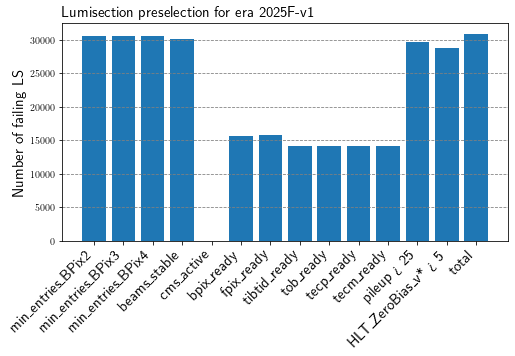

In [13]:
# make a plot of the filter results

# make a table
filter_results_arrays = {key: np.array([el[0]*10000+el[1] for el in val]) for key, val in filter_results.items()}
failed_ls = np.unique(np.concatenate(list(filter_results_arrays.values())))
nfiltered = {key: len(val) for key, val in filter_results_arrays.items()}
nfiltered['total'] = len(failed_ls)

# make a figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(nfiltered.keys(), nfiltered.values())
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)
ax.set_ylabel('Number of failing LS', fontsize=15)
ax.grid(which='both', axis='y', color='gray', linestyle='dashed')
ax.text(0, 1.03, f'Lumisection preselection for era {era}', transform=ax.transAxes, fontsize=15)
plt.show()

In [14]:
# find out why a given lumisection did not pass the selections

test_runlumis = [(395762, 1083)]
for runlumi in test_runlumis:
    failkeys = []
    for key, values in filter_results.items():
        if list(runlumi) in values: failkeys.append(key)
    if len(failkeys)==0:
        print(f'Lumisection {runlumi} not found in filter info, i.e. it did not seem to have failed any of the selections.')
    else:
        print(f'Lumisection {runlumi} failed the following selections:')
        print(failkeys)

Lumisection (395762, 1083) not found in filter info, i.e. it did not seem to have failed any of the selections.


In [15]:
# load data for plotting some random (or not random) examples

# general settings
do_extended_loss_plots = True
do_combined_loss_plot = True
do_combined_loss_mask_plot = False

# random lumisections
nplot = 0
#random_ids = np.random.choice(len(available_run_numbers), size=min(nplot, len(available_run_numbers)), replace=False)
#selected_run_numbers = available_run_numbers[random_ids]
#selected_ls_numbers = available_ls_numbers[random_ids]
#random_ids = np.random.choice(len(flagged_run_numbers), size=min(nplot, len(flagged_run_numbers)), replace=False)
#selected_run_numbers = flagged_run_numbers[random_ids]
#selected_ls_numbers = flagged_ls_numbers[random_ids]

# alternative: specific selected lumisections
selected_runlumis = [(397568, 634), (397569, 1), (397580, 57)]
selected_run_numbers = [el[0] for el in selected_runlumis]
selected_ls_numbers = [el[1] for el in selected_runlumis]

if len(selected_run_numbers) > 0:
    
    # calculate random indices and load data
    print('Loading data...')
    dfs = {}
    mes = {}
    for layer in layers:
        dfs[layer] = iotools.read_lumisections(input_files[era][layer], selected_run_numbers, selected_ls_numbers, mode='batched')
        mes[layer], runs, lumis = dftools.get_mes(dfs[layer], xbinscolumn='x_bin', ybinscolumn='y_bin', runcolumn='run_number', lumicolumn='ls_number')

Loading data...


Processing...
Thresholding...
Combining layers...
Applying loss mask...
Plotting...


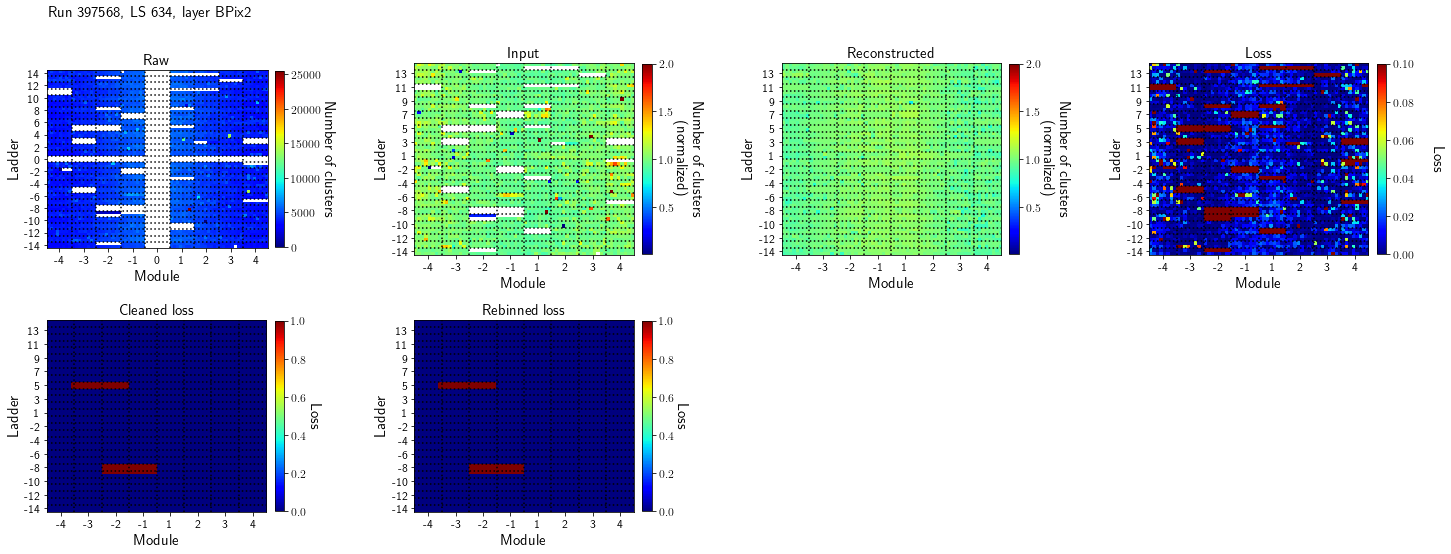

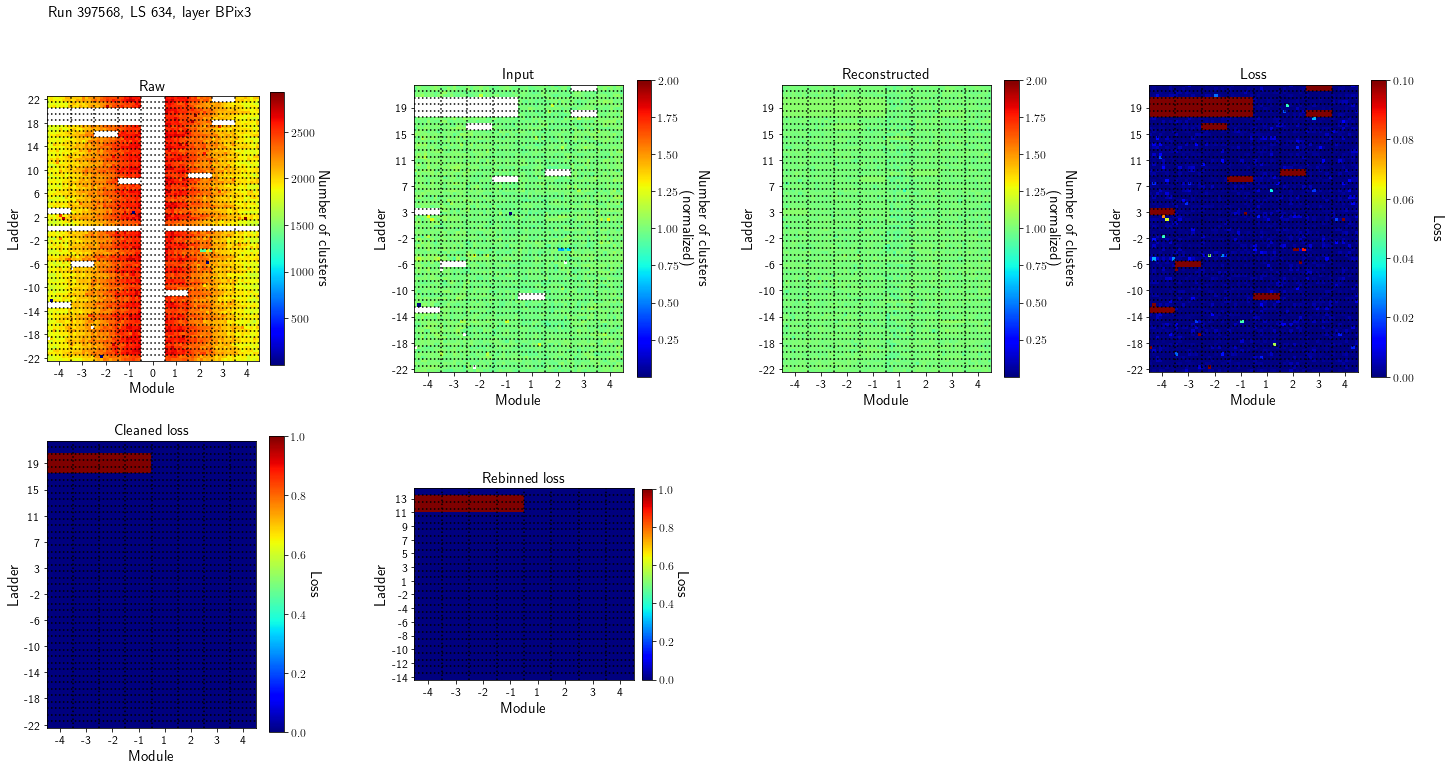

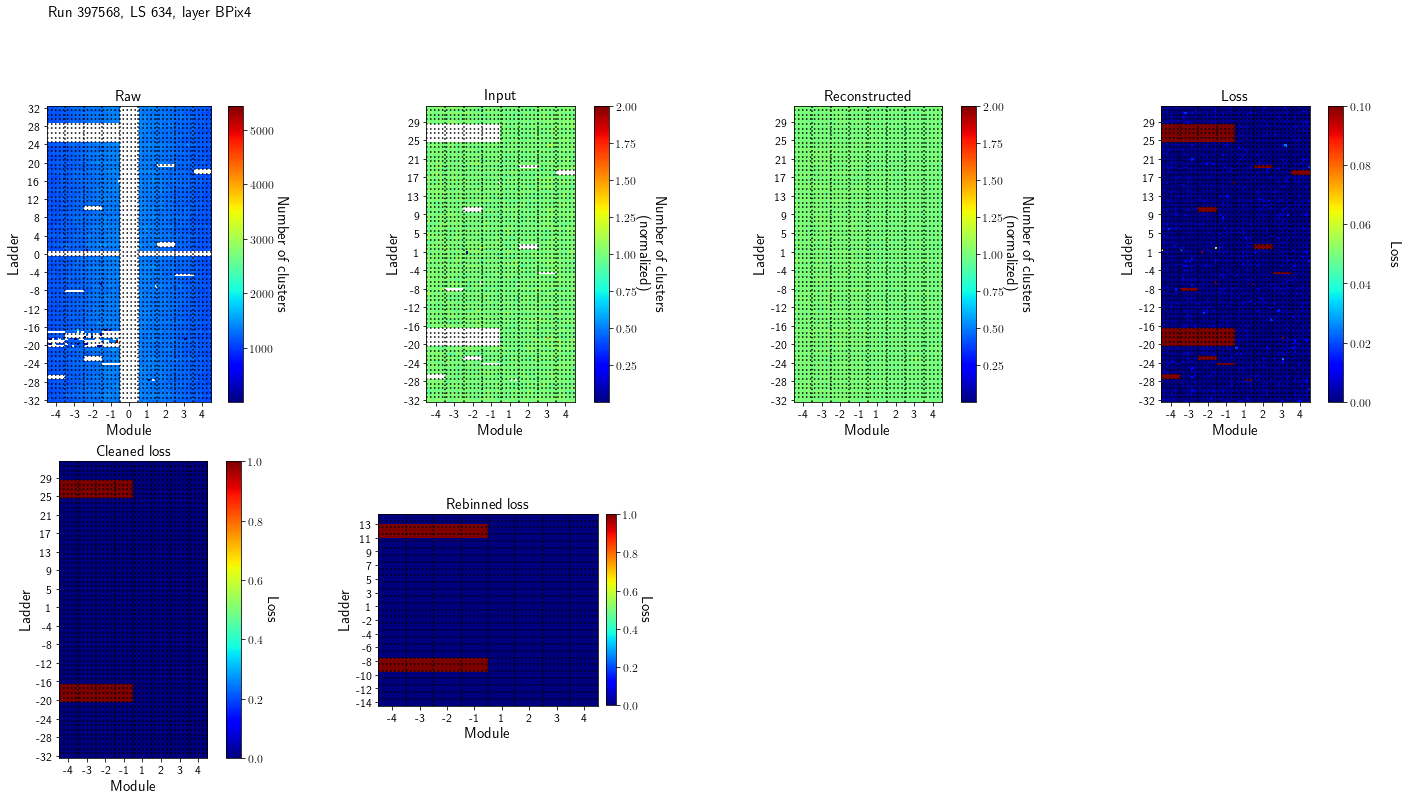

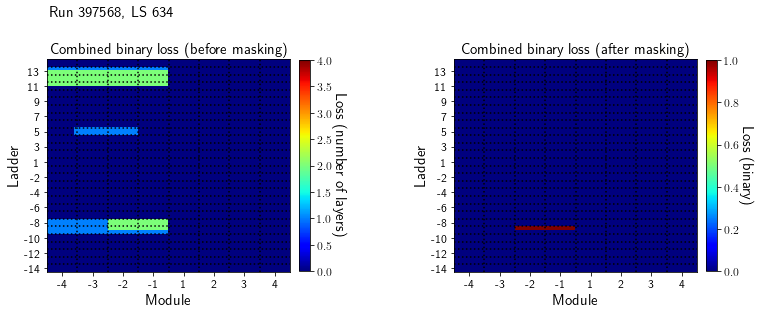

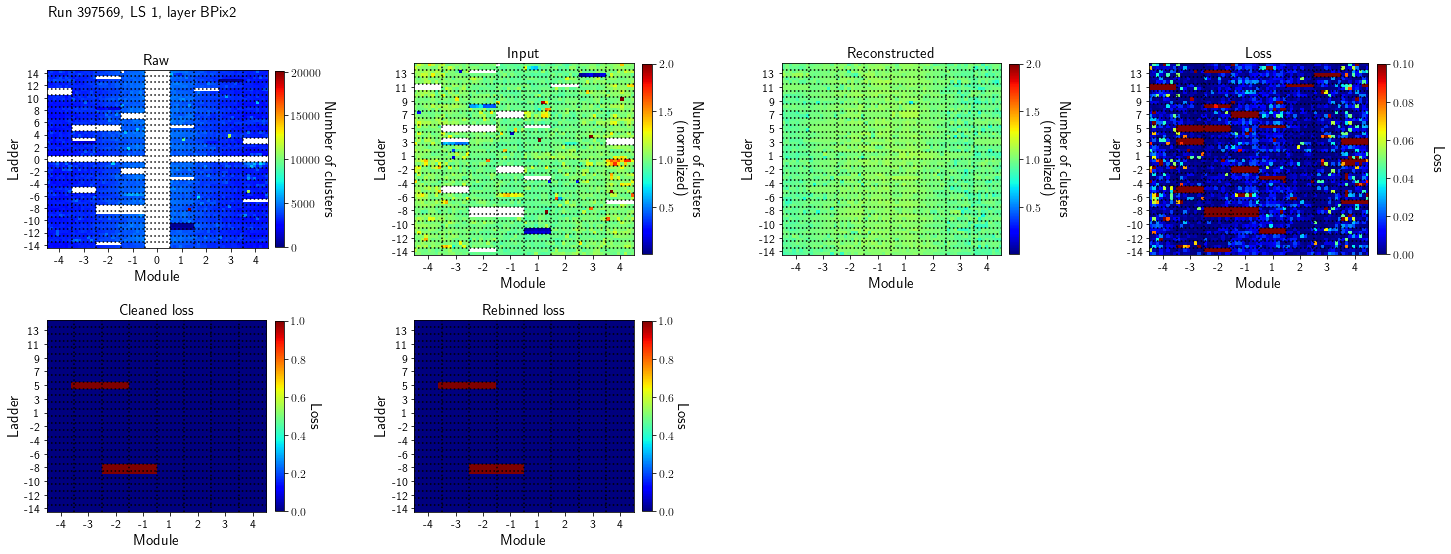

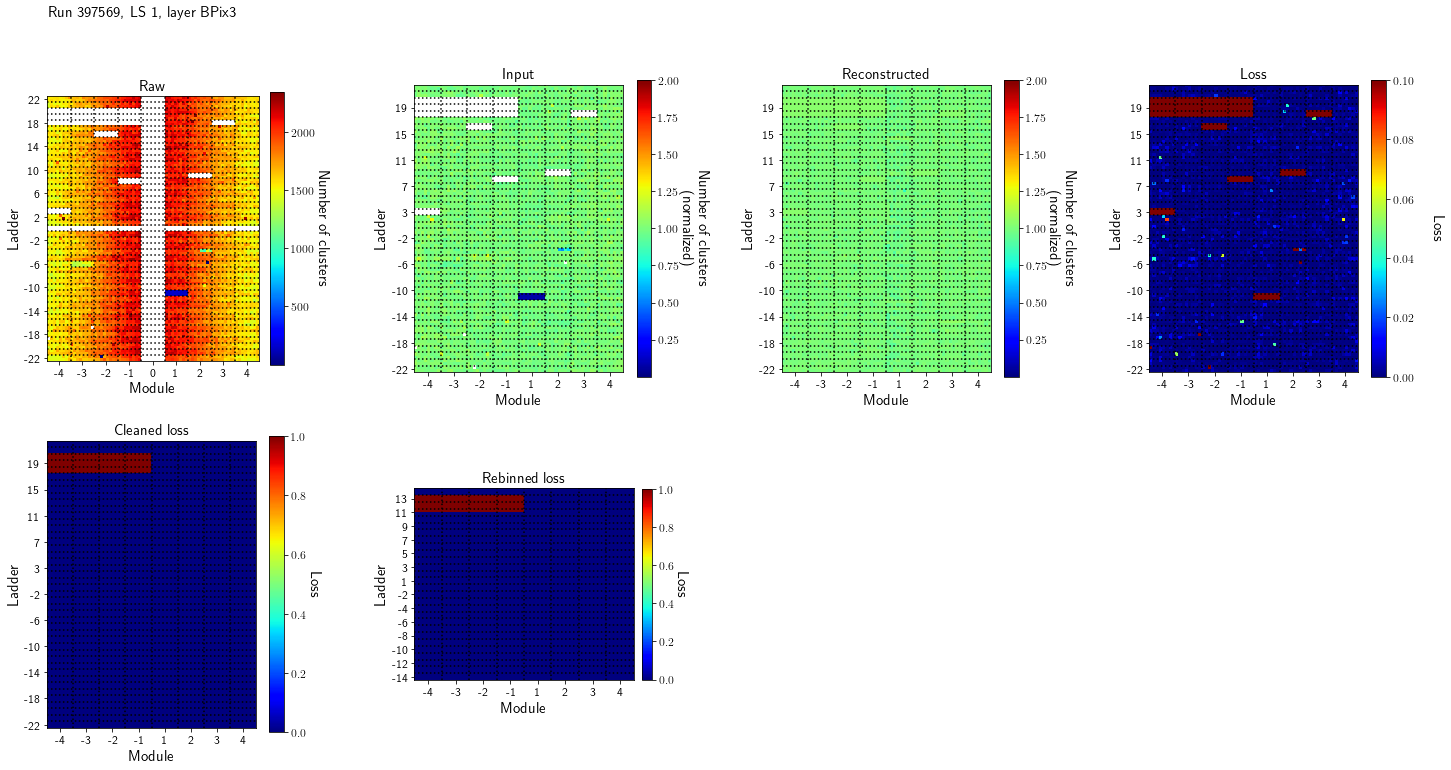

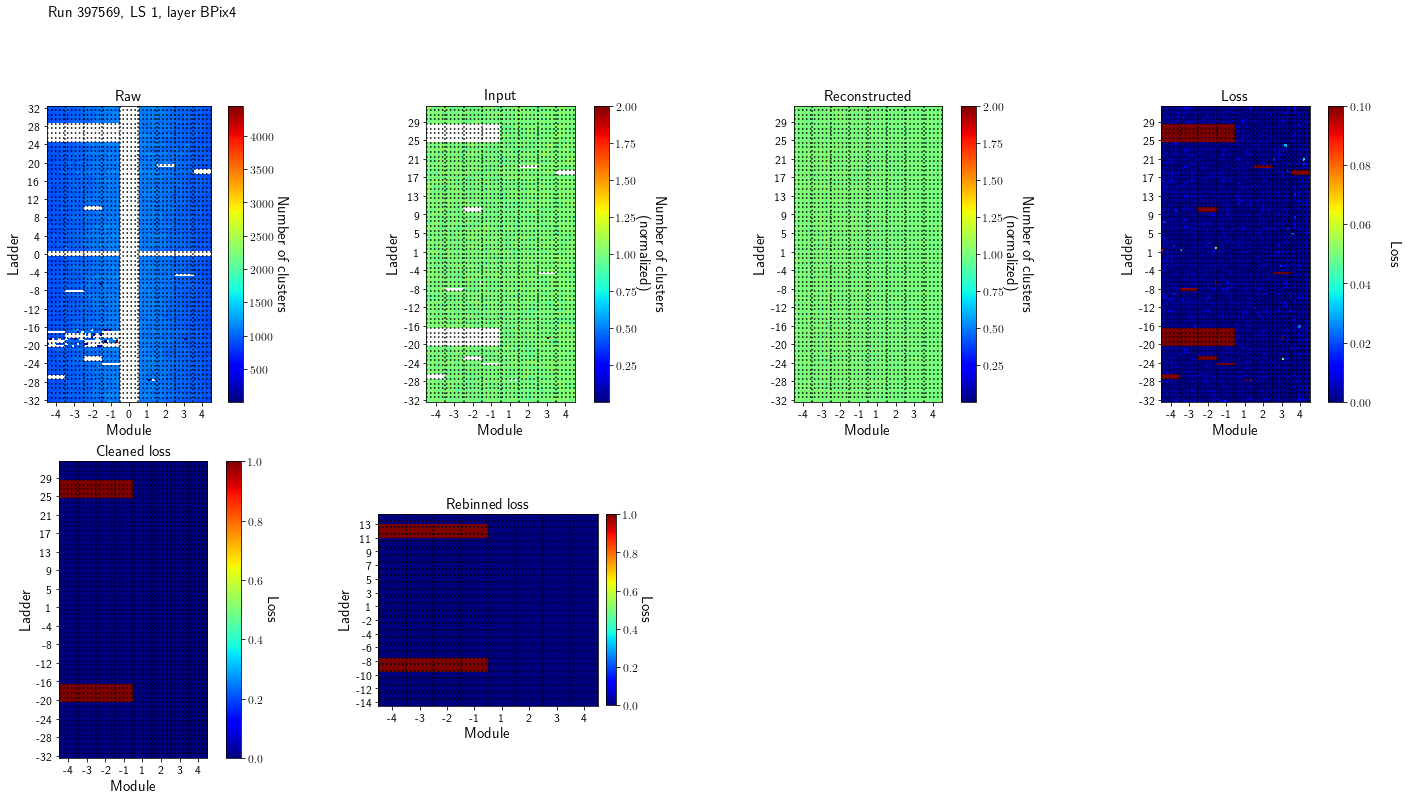

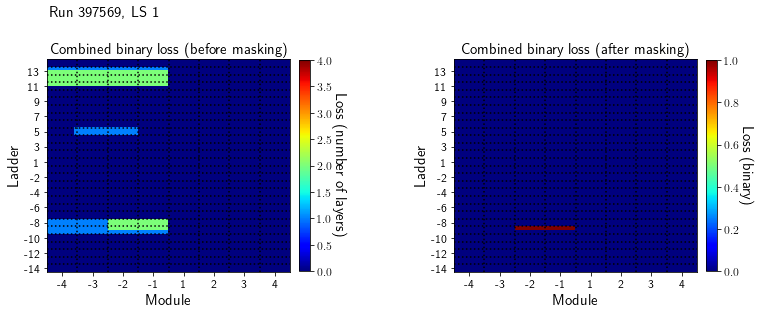

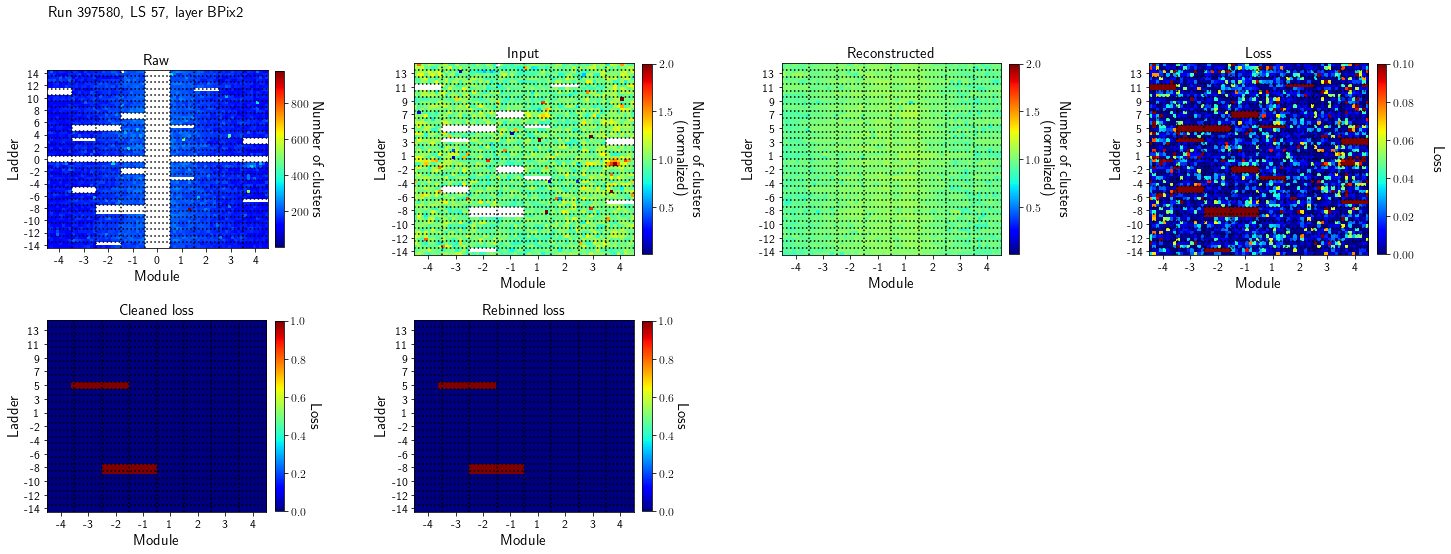

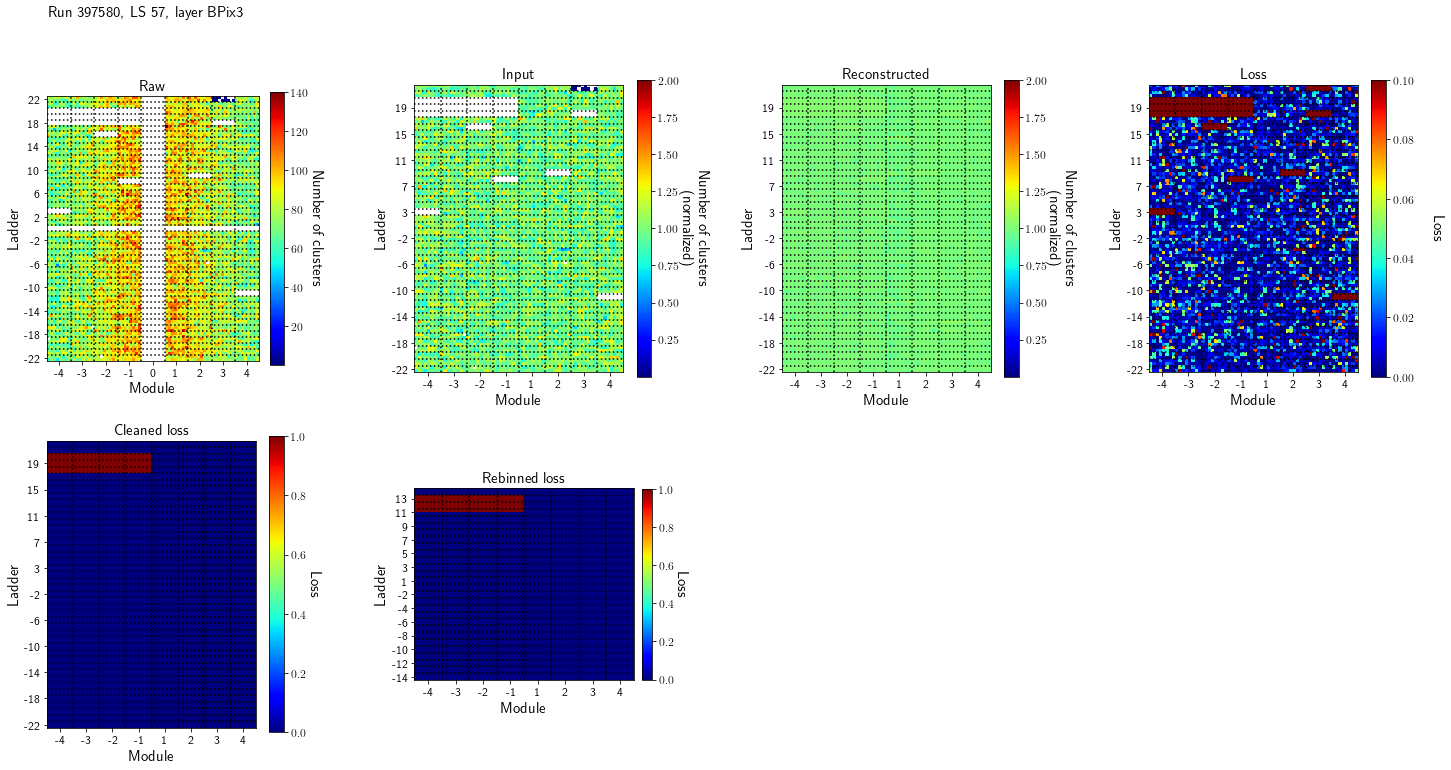

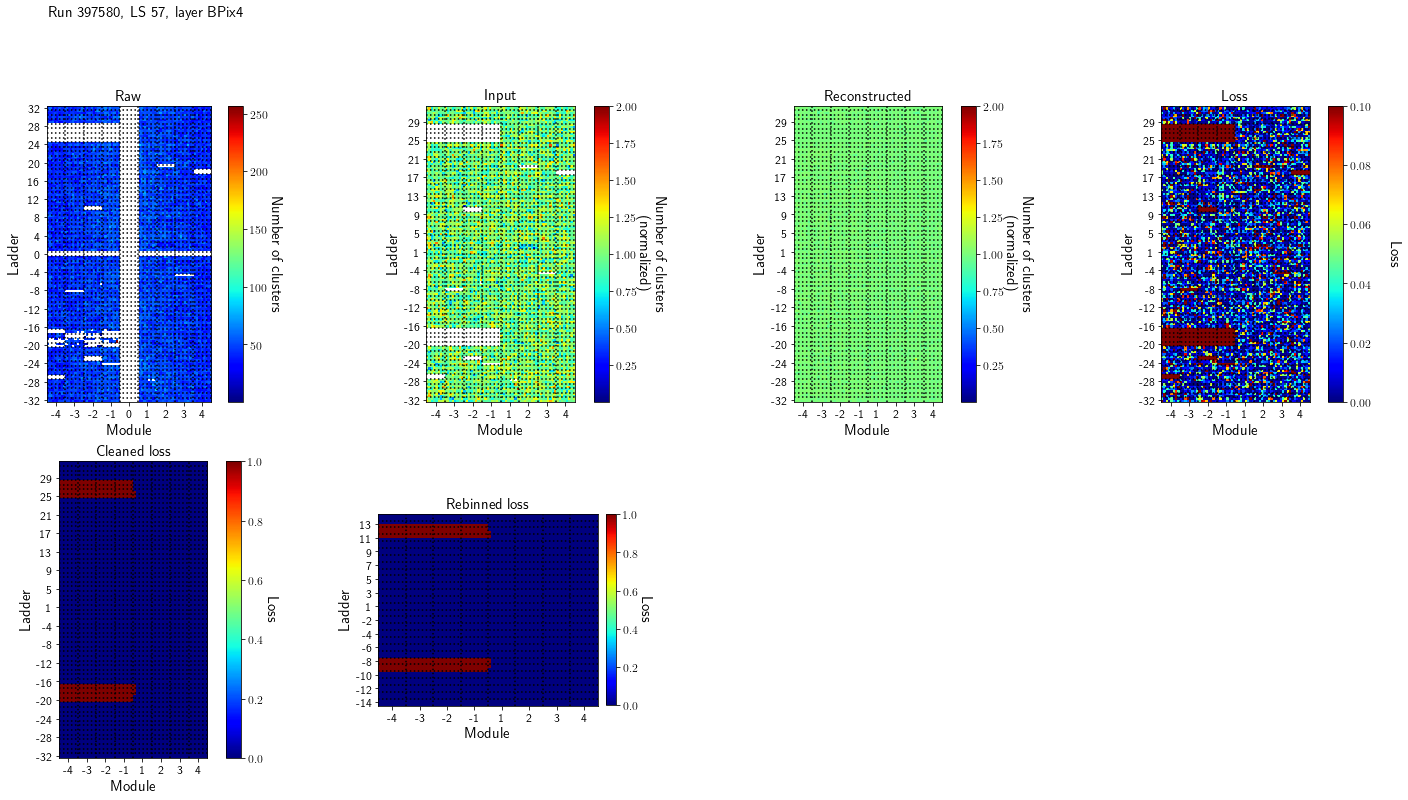

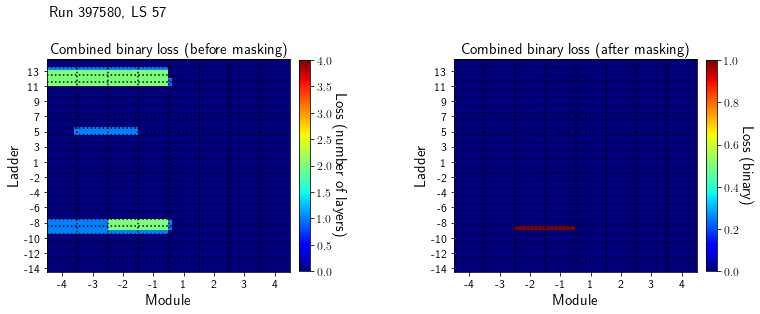

In [16]:
# plot examples

if len(selected_run_numbers) > 0:
    
    # preprocess and predict
    print('Processing...')
    mes_preprocessed = {}
    mes_pred = {}
    losses = {}
    for layer in layers:
        mes_preprocessed[layer] = preprocessors[era][layer].preprocess(dfs[layer])
        this_mes_preprocessed = np.copy(mes_preprocessed[layer])
        # (make a copy for some additional processing before inference
        #  that does not need to go in the plot)
        if preprocessors is not None:
            threshold = 5
            this_mes_preprocessed[this_mes_preprocessed > threshold] = threshold
        if preprocessors is not None:
            this_mes_preprocessed[this_mes_preprocessed == 0] = 1
        mes_pred[layer] = nmfs[era][layer].predict(this_mes_preprocessed)
        losses[layer] = np.square(mes_preprocessed[layer] - mes_pred[layer])
    
    # automasking
    if do_automasking:
        print('Applying automasks...')
        for layer in layers:
            subsystem = f'BPix{layer}'
            automask_maps = automask_reader.get_automask_maps_for_ls(selected_run_numbers, selected_ls_numbers, subsystem, invert=True)
            automask_maps = automask_map_preprocessors[layer].preprocess_mes(automask_maps, None, None)
            losses[layer] = np.multiply(losses[layer], automask_maps)
     
    # thresholding
    print('Thresholding...')
    losses_clustered = {}
    for layer in layers:
        losses_clustered[layer] = clustering.cluster_loss_multithreshold(losses[layer], pattern_thresholds)
    
    # make rebinned and overlayed loss map
    print('Combining layers...')
    target_shape = losses[layers[0]].shape[1:3]
    losses_rebinned = {}
    losses_combined = np.zeros(losses[layers[0]].shape)
    for layer in layers:
        losses_rebinned[layer] = rebinning.rebin_keep_clip(losses_clustered[layer], target_shape, 1, mode='cv2')
        losses_combined += losses_rebinned[layer]
        
    # optional: do loss masking
    loss_mask = np.zeros(losses_combined.shape)
    if do_loss_masking:
        print('Applying loss mask...')
        loss_mask = np.zeros((1, target_shape[0], target_shape[1]))
        for layer in layers:
            this_loss_mask = loss_masks[era][layer]
            # preprocess
            this_loss_mask = np.expand_dims(this_loss_mask, 0)
            this_loss_mask = loss_mask_preprocessors[layer].preprocess_mes(this_loss_mask, None, None)
            # invert
            this_loss_mask = 1 - this_loss_mask
            # rescale
            this_loss_mask = rebinning.rebin_keep_clip(this_loss_mask, target_shape, 1, mode='cv2')
            # add to total
            loss_mask += this_loss_mask
        loss_mask = np.repeat(loss_mask, len(losses_combined), axis=0)
    
    # apply threshold on combined loss
    losses_final = ((losses_combined >= 2) & (losses_combined > loss_mask)).astype(int)
        
    # make the plots
    print('Plotting...')
    for idx in range(len(selected_run_numbers)):
        run = runs[idx]
        lumi = lumis[idx]
        for layer in layers:
            me_orig = mes[layer][idx, :, :]
            me_preprocessed = mes_preprocessed[layer][idx, :, :]
            me_pred = mes_pred[layer][idx, :, :]
            loss = losses[layer][idx, :, :]
            loss_clustered = losses_clustered[layer][idx, :, :]
            loss_rebinned = losses_rebinned[layer][idx, :, :]
    
            # initialize figure
            nrows = 1
            figheight = 6
            if do_extended_loss_plots:
                nrows = 2
                figheight = 12
            fig, axs = plt.subplots(ncols=4, nrows=nrows, figsize=(24, figheight), squeeze=False)
            
            # plot raw data
            fig, axs[0, 0] = plot_cluster_occupancy(me_orig, fig=fig, ax=axs[0, 0],
                   title='Raw', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Number of clusters',
                   caxtitlesize=15, caxtitleoffset=15)
        
            # overlay automask
            if do_automasking:
                subsystem = f'BPix{layer}'
                automask_map = amreader.get_automask_map_for_ls(run, lumi, subsystem)
                ids = np.nonzero(automask_map.astype(int))
                for yidx, xidx in zip(ids[0], ids[1]):
                    linewidth = 1 if layer>=3 else 2
                    patch = mpl.patches.Rectangle((xidx-0.5, yidx-0.5), 1, 1,
                                      edgecolor='red', linewidth=linewidth,
                                      facecolor='none')
                    axs[0, 0].add_patch(patch)
        
            # plot preprocessed, reconstructed and loss
            fig, axs[0, 1] = plot_cluster_occupancy(me_preprocessed, fig=fig, ax=axs[0, 1],
                   title='Input', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Number of clusters\n(normalized)',
                   caxrange=(1e-6,2),
                   caxtitlesize=15, caxtitleoffset=30)
            fig, axs[0, 2] = plot_cluster_occupancy(me_pred, fig=fig, ax=axs[0, 2],
                   title='Reconstructed', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Number of clusters\n(normalized)',
                   caxrange=(1e-6,2),
                   caxtitlesize=15, caxtitleoffset=30)
            fig, axs[0, 3] = plot_cluster_occupancy(loss, fig=fig, ax=axs[0, 3],
                   title='Loss', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Loss',
                   caxrange=(0, 0.1),
                   caxtitlesize=15, caxtitleoffset=30)
            
            # optional: plot more post-processing steps with the loss map
            if do_extended_loss_plots:
                fig, axs[1, 0] = plot_cluster_occupancy(loss_clustered, fig=fig, ax=axs[1, 0],
                   title=f'Cleaned loss', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Loss',
                   caxrange=(0, 1),
                   caxtitlesize=15, caxtitleoffset=15)
                fig, axs[1, 1] = plot_cluster_occupancy(loss_rebinned, fig=fig, ax=axs[1, 1],
                   title=f'Rebinned loss', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Loss',
                   caxrange=(0, 1),
                   caxtitlesize=15, caxtitleoffset=15)
                fig.delaxes(axs[1, 2])
                fig.delaxes(axs[1, 3])
                
            # plot aesthetics
            plt.subplots_adjust(wspace=0.55)
            if str(layer)=='BPix1': plt.subplots_adjust(hspace=-0.65)
            if str(layer)=='BPix2': plt.subplots_adjust(hspace=-0.35)
            title = f'Run {run}, LS {lumi}, layer {layer}'
            axs[0, 0].text(0.01, 1.3, title, fontsize=15, transform=axs[0, 0].transAxes)
            plt.show()
            plt.close()
            
        # plot the combined loss map
        if do_combined_loss_plot:
            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
            # combined loss before loss masking
            loss_combined = losses_combined[idx, :, :]
            fig, axs[0] = plot_cluster_occupancy(loss_combined, fig=fig, ax=axs[0],
                   title='Combined binary loss (before masking)', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Loss (number of layers)',
                   caxrange=(0, 4),
                   caxtitlesize=15, caxtitleoffset=15)
            # combined loss after loss masking
            loss_final = losses_final[idx, :, :]
            fig, axs[1] = plot_cluster_occupancy(loss_final, fig=fig, ax=axs[1],
                   title='Combined binary loss (after masking)', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Loss (binary)',
                   caxrange=(0, 1),
                   caxtitlesize=15, caxtitleoffset=15)
            plt.subplots_adjust(wspace=0.55)
            title = f'Run {run}, LS {lumi}'
            axs[0].text(0.01, 1.2, title, fontsize=15, transform=axs[0].transAxes)
            plt.show()
            plt.close()
            
    # plot the combined loss mask
    if do_combined_loss_mask_plot:
            loss_mask_combined = loss_mask[0, :, :]
            fig, ax = plt.subplots()
            fig, ax = plot_cluster_occupancy(loss_mask_combined, fig=fig, ax=ax,
                   title='Combined loss mask', titlesize=15,
                   xaxtitlesize=15, yaxtitlesize=15,
                   ticklabelsize=12, colorticklabelsize=12,
                   docolorbar=True, caxtitle='Mask (number of layers)',
                   caxrange=(0, 4),
                   caxtitlesize=15, caxtitleoffset=15)
            title = f'Run {run}, LS {lumi}'
            ax.text(0.01, 1.3, title, fontsize=15, transform=ax.transAxes)
            plt.show()
            plt.close()